<a href="https://colab.research.google.com/github/manishanandyadav666/Application/blob/main/UG_Mines_testing_June_22(9_39_PM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building a simplistic version to check the working of the code

##The changes incorporated: Scale state action and reward. Full state and action space


In [25]:
### Checking for just one node

In [26]:
pip install stable-baselines3[extra]

In [27]:
### With the new distribute_miners() function
import math
import gym
from stable_baselines3 import PPO
#from stable_baselines3 import DDPG
#from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np
import matplotlib.pyplot as plt


class MineEnvironment(gym.Env):
    def __init__(self, initial_battery_levels, total_miners):
        super(MineEnvironment, self).__init__()

        self.initial_battery_levels = initial_battery_levels
        self.actual_battery_levels = initial_battery_levels.copy()
        self.num_sensor_nodes = len(initial_battery_levels)
        self.total_miners = total_miners

        self.predicted_battery_levels = np.random.choice(101, self.num_sensor_nodes)
        self.num_miners_list = np.array([25.0, 12.0, 13.0]) #self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)

        #self.action_space = gym.spaces.MultiDiscrete([6] * self.num_sensor_nodes)
        #self.observation_space = gym.spaces.Box(low=-6, high=6, shape=(self.num_sensor_nodes, 3), dtype=np.float32)
        self.action_space= gym.spaces.Box(low=0,high=1,shape=(self.num_sensor_nodes, ), dtype=np.float32 )
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.num_sensor_nodes, 3), dtype=np.float32)

        self.abl = initial_battery_levels.copy()
        self.pdl = self.predicted_battery_levels.copy()

        self.action_array = np.empty((0, self.num_sensor_nodes))
        self.reward_list = []
        self.error = []
        self.runtime = 0
        # Cooldown related attributes
        self.cooldown_period = 10 # Example cooldown period in steps
        self.cooldown_counter = np.zeros(self.num_sensor_nodes)

        ### Location of the miners
        self.miners_loc_x = np.zeros(self.total_miners)
        self.miners_loc_y = np.zeros(self.total_miners)
        self.min_battery_level = 5
        #self.build_location(self.num_sensor_nodes, total_miners)
         #Initialize node and miner locations
        #self.build_location(self.num_sensor_nodes, total_miners)
        #self.num_miners_list = self.distribute_miners()

    '''def build_location(self, nodes, miners):
        self.nodes = nodes
        self.miners = miners
        self.nodes_loc_x = np.random.uniform(0, 150, self.nodes)
        self.nodes_loc_y = np.random.uniform(0, 150, self.nodes)
        self.miners_loc_x = np.random.uniform(0, 150, self.miners)
        self.miners_loc_y = np.random.uniform(0, 150, self.miners)

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        plt.plot(self.nodes_loc_x, self.nodes_loc_y, 'ro', label='Nodes')
        plt.plot(self.miners_loc_x, self.miners_loc_y, 'bs', label='Miners')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()'''

    '''def calculate_energy(self, d):

        k = 1* 80000  # Number of bits
        r_c = 80  # Communication range
        epsilon_elec = 50e-9  # Energy to run transmitter/receiver
        epsilon_fs = 10e-12  # Energy for short distance
        epsilon_mp = 0.0013e-12  # Energy for long distance
        d_o = math.sqrt(epsilon_fs / epsilon_mp)
        E_t=0
        E_r=0
        if d <= d_o <= r_c:
            E_t = k * epsilon_elec + k * epsilon_fs * d**2
        elif d_o <= d <= r_c:
            E_t = k * epsilon_elec + k * epsilon_mp * d**4
        elif d > r_c:
            E_t = 0
        E_r = k * epsilon_elec
        return E_t, E_r'''

    def reset(self):
        print("Environment is being reset.")
        self.actual_battery_levels = self.initial_battery_levels.copy()
        self.predicted_battery_levels = np.random.choice(101, self.num_sensor_nodes)
        #self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)
        self.cooldown_counter = np.zeros(self.num_sensor_nodes)
        return self.get_state()

    def step(self, action):
        print('The runtime is: ', self.runtime)
        self.runtime += 1
        '''if self.runtime % 5000 == 0:
            self.num_miners_list = self.distribute_miners()'''
        print('Now the action is: ', action)
        self.take_action(action)
        self.abl = np.column_stack((self.abl, self.actual_battery_levels))
        self.pdl = np.column_stack((self.pdl, self.predicted_battery_levels))
        state = self.get_state()
        reward = self.get_reward()
        print('Now the reward is: ', reward)
        self.reward_list.append(reward)
        done = False
        '''# Here we want to define an episode length or other termination conditions
        if self.runtime % 2048 == 0:  # Example condition for episode termination
        done = True
        print("Episode ended. Environment will reset.")'''

        # Check if any battery level has reached the minimum threshold
        done = np.any(self.actual_battery_levels <= self.min_battery_level)
        if done:
            print("Battery level reached the minimum threshold. Environment will reset.")
            self.reset()
        info = {}
        return state, reward, done, info

    def get_state(self):
        print('Inside get_state funciton')
        state = np.column_stack((self.actual_battery_levels/100.0, self.num_miners_list/50.0, self.battery_change/100.0))
        #state = np.column_stack((self.actual_battery_levels, self.num_miners_list, self.battery_change))
        print("The state is: ", state)
        return state

    '''def distribute_miners(self):
      #
      print("Inside the distribute_miner function")
      new_miners_loc_x = np.zeros(self.total_miners)
      new_miners_loc_y = np.zeros(self.total_miners)

      # Define the proportions
      proportions = [0.5, 0.3, 0.2]
      nodes = list(range(self.num_sensor_nodes))

      # Determine the number of miners to assign to each node
      miners_per_node = [int(self.total_miners * p) for p in proportions]

      # Correct any rounding issues to ensure the total number of miners is correct
      while sum(miners_per_node) < self.total_miners:
          miners_per_node[0] += 1
      while sum(miners_per_node) > self.total_miners:
          miners_per_node[0] -= 1

      # Assign miners to nodes based on the calculated proportions
      assigned_miners = 0
      for node_index, num_miners in enumerate(miners_per_node):
          for _ in range(num_miners):
              new_miners_loc_x[assigned_miners] = self.nodes_loc_x[node_index]
              new_miners_loc_y[assigned_miners] = self.nodes_loc_y[node_index]
              assigned_miners += 1

        # If there are any remaining miners (due to rounding issues), assign them randomly
      for i in range(assigned_miners, self.total_miners):

            node_index = np.random.choice(nodes)
            new_miners_loc_x[i] = self.nodes_loc_x[node_index]
            new_miners_loc_y[i] = self.nodes_loc_y[node_index]

      # Update the miner locations
      self.miners_loc_x = new_miners_loc_x
      self.miners_loc_y = new_miners_loc_y

      # Update the distance matrix
      self.nodes_miners_d = np.zeros((self.num_sensor_nodes, self.total_miners))
      for k in range(self.num_sensor_nodes):
          for l in range(self.total_miners):
              self.nodes_miners_d[k][l] = np.sqrt(
                  np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                  np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

      # Determine the closest node for each miner
      num_miners_list = np.zeros(self.num_sensor_nodes, dtype=int)
      for l in range(self.total_miners):
          closest_node = np.argmin(self.nodes_miners_d[:, l])
          num_miners_list[closest_node] += 1

      return num_miners_list'''



    '''def calculate_battery_decay(self):
      #
      print('Inside battery decay function')
      full_energy = 10.0
      battery_capacity = 100.0
      for i in range(self.num_sensor_nodes):
          #Just
          total_energy_consumed = 0
          miners_connected = self.num_miners_list[i]  # Number of miners connected to this sensor node
          for miner_idx in range(miners_connected):
            #
              if self.num_miners_list[i] > 0:
                  # Only consider miners that are connected to this sensor node
                  d = self.nodes_miners_d[i][miner_idx]
                  E_T, E_R = self.calculate_energy(d)
                  total_energy_consumed += (E_T + E_R)
                  #print('The total energy consumed is: ', total_energy_consumed)
          battery_decay = (total_energy_consumed / full_energy) * battery_capacity
          print('The battery decay is: ', battery_decay)
          self.actual_battery_levels[i] -= battery_decay


          if self.actual_battery_levels[i] <= 0:
            self.actual_battery_levels[i] = 5
          else:
            self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)'''






    def calculate_battery_decay(self):

      for i in range(self.num_sensor_nodes):
          if self.cooldown_counter[i] > 0:
              self.cooldown_counter[i] -= 1
              continue
          battery_decay = 1
          self.actual_battery_levels[i] -= battery_decay

          if self.actual_battery_levels[i] <= self.min_battery_level:
                self.actual_battery_levels[i] = self.min_battery_level



    # A new function to calculate battery-decay, where the battery decays by 1 every time-step
    '''def calculate_battery_decay(self):
      for i in range(self.num_sensor_nodes):
        battery_decay= 5
        self.actual_battery_levels[i] -= battery_decay

        if self.actual_battery_levels[i] <= 0:
          self.actual_battery_levels[i] = 5
        else:
          self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)'''

    def take_action(self, action):
        self.action_array = np.vstack((self.action_array, action))
        self.predicted_battery_levels = action*100
        self.predicted_battery_levels = np.clip(self.predicted_battery_levels, 0, 100)
        self.calculate_battery_decay()
        self.battery_change = self.actual_battery_levels - self.predicted_battery_levels
        print('The change in battery level is: ', self.battery_change)
        self.error.append(self.battery_change)

    def get_reward(self):
        B_dt = np.abs(self.actual_battery_levels - self.predicted_battery_levels)
        rewards = [-(b_dt_value) for b_dt_value in B_dt]
        return np.exp((np.sum(rewards)/300))


# Initialize the parameters
initial_battery_levels = np.array([100.0, 75.0, 50.0])  # Initial battery levels for all sensor nodes
total_miners = 50  # Total number of miners

# Create the custom environment for multiple sensor nodes
mine_env = MineEnvironment(initial_battery_levels, total_miners)

# Create and train the DDPG model
ppo_model = PPO("MlpPolicy", mine_env, verbose=1)
# Create and train the DDPG model
# The noise objects for DDPG
#n_actions = mine_env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

#model = ppo_model("MlpPolicy", mine_env, verbose=1)
epochs = 400
for epoch in range(epochs):
    mine_env.reset()
    ppo_model.learn(total_timesteps=2048)

Streaming output truncated to the last 5000 lines.
The change in battery level is:  [-2.84666824  0.63959503 10.        ]
Inside get_state funciton
The state is:  [[ 0.6         0.5        -0.02846668]
 [ 0.35        0.24        0.00639595]
 [ 0.1         0.26        0.1       ]]
Now the reward is:  0.9560412570832019
The runtime is:  342416
Now the action is:  [0.61944413 0.3387564  0.        ]
The change in battery level is:  [-2.94441223  0.12435913  9.        ]
Inside get_state funciton
The state is:  [[ 0.59        0.5        -0.02944412]
 [ 0.34        0.24        0.00124359]
 [ 0.09        0.26        0.09      ]]
Now the reward is:  0.96056921506641
The runtime is:  342417
Now the action is:  [0.58084655 0.31243482 0.        ]
The change in battery level is:  [-0.08465576  1.75651741  8.        ]
Inside get_state funciton
The state is:  [[ 0.58        0.5        -0.00084656]
 [ 0.33        0.24        0.01756517]
 [ 0.08        0.26        0.08      ]]
Now the reward is:  0.967

KeyboardInterrupt: 

In [28]:
import pickle

# Function to save variables to a file
def save_variables(filename, variables):
    with open(filename, 'wb') as f:
        pickle.dump(variables, f)

# Function to load variables from a file
def load_variables(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Retrieve the values of actions and rewards
act_0 = mine_env.action_array[0:, :]
act_1 = mine_env.action_array[1:, :]
act_2 = mine_env.action_array[2:, :]
rew = mine_env.reward_list
data = mine_env.error
actual= mine_env.abl
predicted= mine_env.pdl

# Create a dictionary to store all variables
variables = {
    'act_0': act_0,
    'act_1': act_1,
    'act_2': act_2,
    'rew': rew,
    'data': data,
    'actual': actual,
    'predicted': predicted,
}

# Save the variables to a file
save_variables('mine_env_variables_June_16_1_15_PM.pkl', variables)

# Load the variables from a file (example usage)
loaded_variables = load_variables('mine_env_variables_June_16_1_15_PM.pkl')

# Access the variables
loaded_act_0 = loaded_variables['act_0']
loaded_act_1 = loaded_variables['act_1']
loaded_act_2 = loaded_variables['act_2']
loaded_rew = loaded_variables['rew']
loaded_data = loaded_variables['data']
loaded_actual = loaded_variables['actual']
loaded_predicted = loaded_variables['predicted']

# Print the loaded variables

# Example of printing the loaded data
print("Loaded act_0:", loaded_act_0)
print("Loaded act_1:", loaded_act_1)
print("Loaded act_2:", loaded_act_2)
print("Loaded rewards:", loaded_rew)
print("Loaded data:", loaded_data)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
### Retrieving the values of actions and reward
act_0= mine_env.action_array[0:, :]
act_1= mine_env.action_array[1:, :]
act_2= mine_env.action_array[2:, :]
rew= mine_env.reward_list

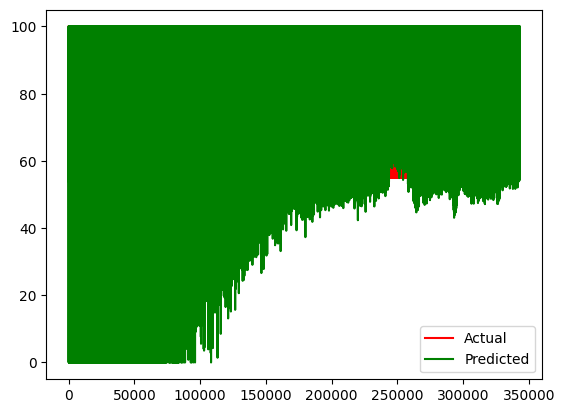

In [30]:
## Printing actual and predicted values
### Function to print graph
import matplotlib.pyplot as plt
ar_1= mine_env.abl[0,:]
ar_2= mine_env.pdl[0, :]
ac=ar_1
bl= ar_2
t= np.arange(len(ar_2))
#fig, ax = plt.subplots()
#ax.plot(t, bl)
plt.plot(t, ac, color='r', label='Actual')
plt.plot(t, bl, color='g', label='Predicted')

#ax.set(xlabel='time_steps', ylabel='battery_level',
       #title='Actual VS Predicted')
plt.legend()
plt.show()

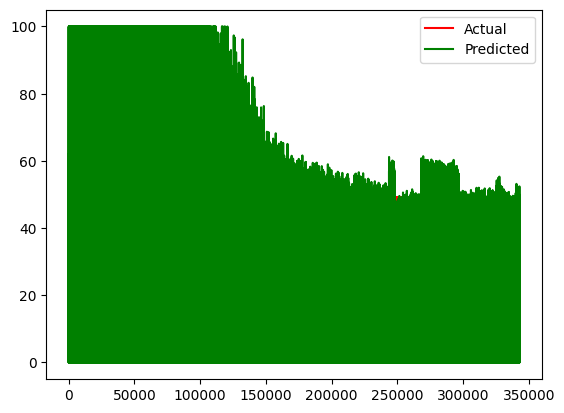

In [31]:
## Printing actual and predicted values
### Function to print graph
import matplotlib.pyplot as plt
ar_1= mine_env.abl[2,:]
ar_2= mine_env.pdl[2, :]
ac=ar_1
bl= ar_2
t= np.arange(len(ar_2))
#fig, ax = plt.subplots()
#ax.plot(t, bl)
plt.plot(t, ac, color='r', label='Actual')
plt.plot(t, bl, color='g', label='Predicted')

#ax.set(xlabel='time_steps', ylabel='battery_level',
       #title='Actual VS Predicted')
plt.legend()
plt.show()

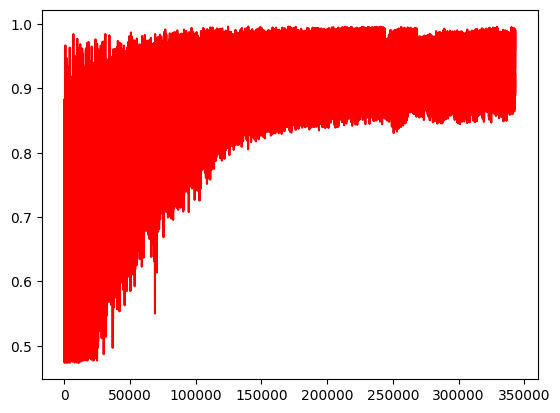

In [32]:
### Plot the reward function
rew= mine_env.reward_list
rt= np.arange(len(rew))
plt.plot(rt, rew, color='r', label='rewards')

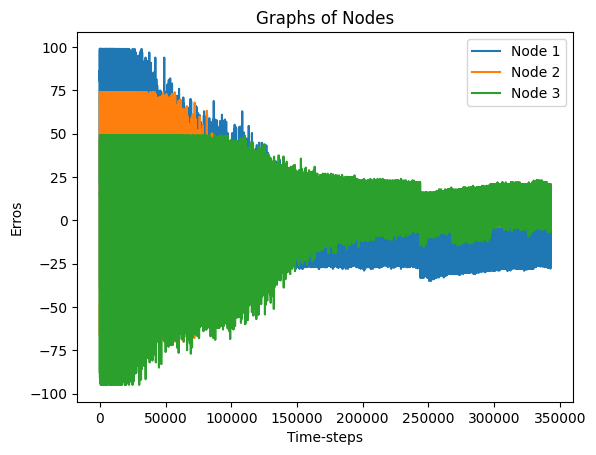

In [36]:
### Plot the error values
import matplotlib.pyplot as plt

# Your list of arrays
data = mine_env.error

# Extracting elements from each array
element1 = [arr[0] for arr in data]
element2 = [arr[1] for arr in data]
element3 = [arr[2] for arr in data]

# Generating x-values (assuming each array is evenly spaced)
x_values = list(range(len(data)))

# Plotting the graphs
plt.plot(x_values, element1, label='Node 1')
plt.plot(x_values, element2, label='Node 2')
plt.plot(x_values, element3, label='Node 3')

plt.xlabel('Time-steps')
plt.ylabel('Erros')
plt.title('Graphs of Nodes')
plt.legend()
plt.show()

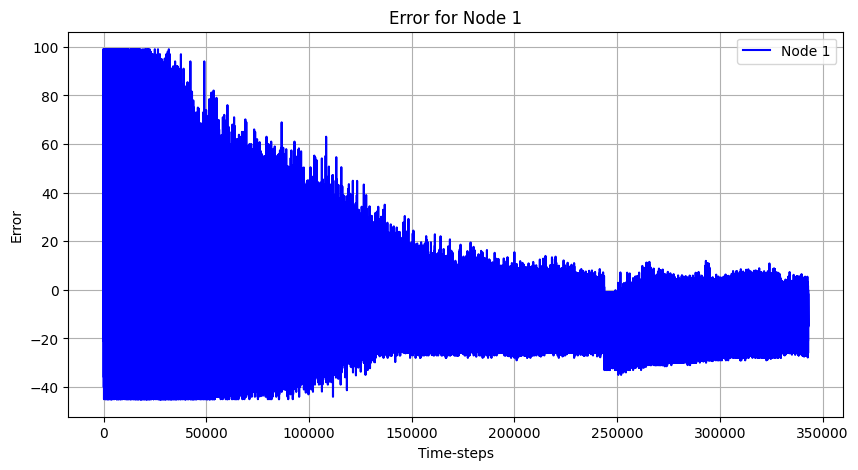

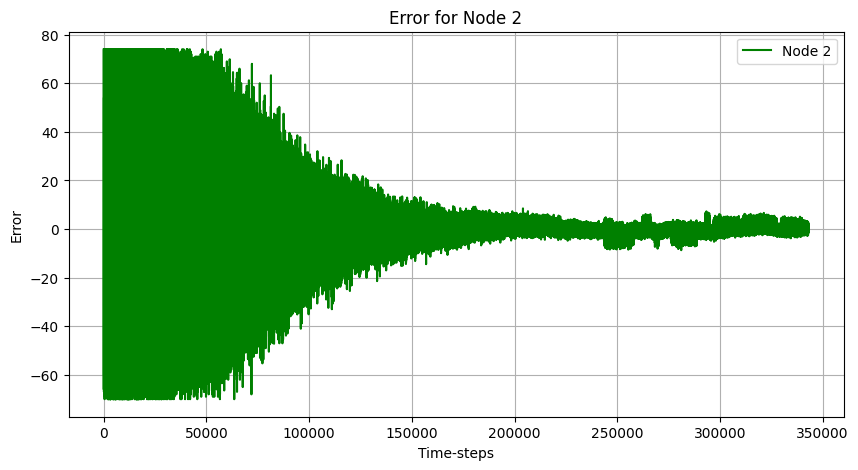

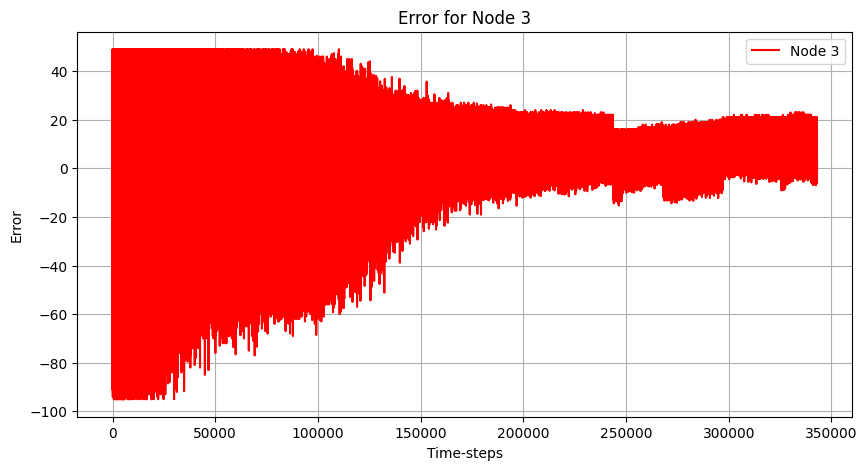

In [34]:
import matplotlib.pyplot as plt

# Your list of arrays (replace mock_error with mine_env.error in actual usage)
import numpy as np
mock_error = [np.random.rand(3) for _ in range(100)]
data = mine_env.error  # Replace with mine_env.error in actual usage

# Extracting elements from each array
element1 = [arr[0] for arr in data]
element2 = [arr[1] for arr in data]
element3 = [arr[2] for arr in data]

# Generating x-values (assuming each array is evenly spaced)
x_values = list(range(len(data)))

# Plotting the graphs in separate figures
# Plot for Node 1
plt.figure(figsize=(10, 5))
plt.plot(x_values, element1, label='Node 1', color='b')
plt.xlabel('Time-steps')
plt.ylabel('Error')
plt.title('Error for Node 1')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Node 2
plt.figure(figsize=(10, 5))
plt.plot(x_values, element2, label='Node 2', color='g')
plt.xlabel('Time-steps')
plt.ylabel('Error')
plt.title('Error for Node 2')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Node 3
plt.figure(figsize=(10, 5))
plt.plot(x_values, element3, label='Node 3', color='r')
plt.xlabel('Time-steps')
plt.ylabel('Error')
plt.title('Error for Node 3')
plt.legend()
plt.grid(True)
plt.show()